Spark Session web UI: http://10.50.221.199:4040
+----------+-----+-------+--------------------+------+-------+------+--------------------+---------+-----+-----+
|appearance|aroma|beer_id|           beer_name|brewer|overall|palate|              review|review_id|style|taste|
+----------+-----+-------+--------------------+------+-------+------+--------------------+---------+-----+-----+
|       4.0|  6.0|  45842|John Harvards Sim...|  3084|   13.0|   3.0|On tap at the Spr...|        0|   17|  6.0|
|       4.0|  6.0|  45842|John Harvards Sim...|  3084|   13.0|   4.0|On tap at the Joh...|        1|   17|  7.0|
|       4.0|  5.0|  95213|John Harvards Cri...|  3084|   14.0|   3.0|UPDATED: FEB 19, ...|        2|   33|  6.0|
|       2.0|  4.0|  65957|John Harvards Fan...|  3084|    8.0|   2.0|On tap the Spring...|        3|   33|  4.0|
|       5.0|  8.0|  41336|John Harvards Van...|  3084|   16.0|   4.0|Springfield, PA l...|        5|   58|  7.0|
|       4.0|  5.0|  80424|John Harvards Ame...| 

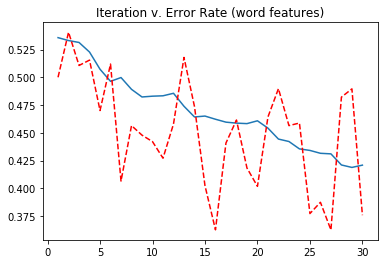

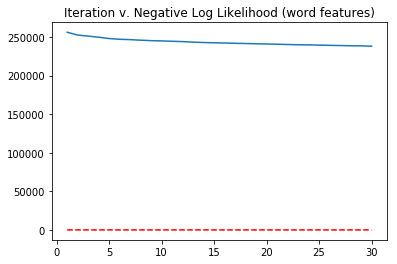


Entering part 3
------------------- EPOCH 1 ------------------------
betas: [ 0.28   0.57   0.285  0.58   0.66 ]
lambda: 5
learning rate: 0.01
Error rate: 0.463531641605
Negative Log Likelihood: 5343950.58604
------------------- EPOCH 2 ------------------------
betas: [ -0.65903164  -1.01886113  -0.54832123 -10.15246121  -0.84330064]
lambda: 5
learning rate: 0.00707106781187
Error rate: 0.536468358395
Negative Log Likelihood: 75789017.1504
------------------- EPOCH 3 ------------------------
betas: [ 0.64341465  1.41864594  0.68422467  1.29364998  1.65335247]
lambda: 5
learning rate: 0.0057735026919
Error rate: 0.463531641605
Negative Log Likelihood: 12254268.5392
------------------- EPOCH 4 ------------------------
betas: [-0.09875608  0.06271364 -0.03498657 -8.14103252  0.33068485]
lambda: 5
learning rate: 0.005
Error rate: 0.533903727282
Negative Log Likelihood: 57377209.3315
------------------- EPOCH 5 ------------------------
betas: [ 1.00299143  2.19196112  1.05496482  2.9785324

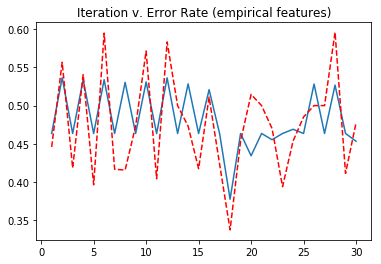

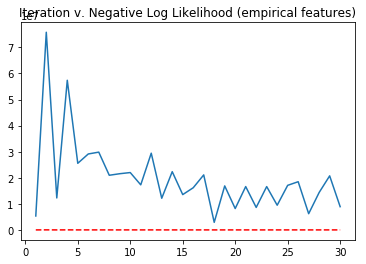

In [1]:
import random
import numpy as np
import scipy.io
import scipy
import os
import json
import string
import re
import math
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.mllib.clustering import KMeans
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.classification import StreamingLogisticRegressionWithSGD
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.mllib.feature import PCA

from scipy.sparse import coo_matrix as COO_matrix

from pyspark.mllib.linalg import Vectors


#################################################################################################
# Part 1:
def beerIDMap(row):
    return (row['beer_id'], (row['overall'], 1))

def beerIDstdMap(row):
    return (row['beer_id'], (row['overall'], row['overall'] ** 2, 1))

def brewerIDMap(row):
    return (row['brewer'], (row['overall'], 1))

def brewerIDstdMap(row):
    return (row['brewer'], (row['overall'], row['overall'] ** 2, 1))

def avgReduce(x, y): # to be called with reduceByKey
    return (x[0] + y[0], x[1] + y[1])

def stdReduce(x, y): # to be called with reduceByKey
    return (x[0] + y[0], x[1] + y[1], x[2] + y[2])

# Part 2:
def sparseReviewMap(row):
    score = row['overall']
    depunctuated_review = re.sub(r"\s+", ' ', row['review'])
    review = depunctuated_review.lower().split()
    wordcount_dict = {}
    for word in review:
        if word in GLOBAL_VOCAB_DICT:
            if word not in wordcount_dict:
                wordcount_dict[word] = 0
            wordcount_dict[word] += 1
    
    data = []
    col_indicies = []
    row_indicies = []
    for i in range(len(GLOBAL_VOCAB_KEY_ORDER)):
        key = GLOBAL_VOCAB_KEY_ORDER[i]
        if key in wordcount_dict:
            data.append(wordcount_dict[key])
            col_indicies.append(i)
            row_indicies.append(0)
#     for word, count in GLOBAL_VOCAB_ORDER_DICT:
#         data.append(word)
#         row_indicies.append(GLOBAL_VOCAB_ORDER_DICT[word])
    
    label = 0
    if score >= 14:
        label = 1
        
    coo_matrix = COO_matrix((data, (row_indicies, col_indicies)), shape=(1, GLOBAL_VOCAB_LEN))
    return (label, coo_matrix)

def sparseLabelsMap(point):
    return point[0]

def sparseFeaturesMap(point):
    return point[1]

def processBatch(beta_vector, X_t_matrix, y_col_vector, pi_col_vector, learning_rate, lambda_val):

    part1 = learning_rate * np.matmul(X_t_matrix, np.subtract(y_col_vector, pi_col_vector))
    part2 = 2 * learning_rate * lambda_val * beta_vector

    return beta_vector + part1 - part2

def logisticPredictMap(row, betas):
    label = row[0]
    data = np.multiply(row[1].toarray(), betas)
    prob = np.sum(data)
    prediction = 0
    if prob > .5:
        prediction = 1
    return (label, prediction)

def errorRateMap(row):
    if int(row[0]) == row[1]:
        return (1, 1)
    else:
        return (0, 1)
def errorRateReduce(x, y):
    return (x[0] + y[0], x[1] + y[1])

# def cooColMap(row):
#     return (row[1], row[0].nonzero())

def piMap(row, beta_vector):
    
    pi_base = np.matmul(beta_vector, -1.0 * np.transpose(row))
    pi = 1.0 / (np.exp(pi_base) + 1.0)
    
    return pi

def calcNLogLikelihoodMap(row, beta_vector):
    label = row[0]
    data = row[1].toarray()
    
    bXi = np.matmul(beta_vector, data.transpose())
    
    part1 = label * bXi
    part2 = np.log(1.0 + np.exp(bXi))
    return -1.0 * (part1 - part2)

def empCalcNLogLikelihoodMap(row, beta_vector):
    label = row[0]
    data = row[1]
    
    bXi = np.matmul(beta_vector, np.transpose(data))
    
    part1 = label * bXi
    part2 = np.log(1.0 + np.exp(bXi))
    return -1.0 * (part1 - part2)

def calcNLogLikelihoodReduce(x, y):
    return x + y 

# part 3 functions
def empiricalReviewMap(row):
    score = row['overall']
    
    label = 0
    if score >= 14:
        label = 1
        
    features = []
    for key in GLOBAL_P3_ORDER:
        features.append(float(row[key]))
        
    return (label, np.array(features))

def empiricalLogisticPredictMap(row, betas):
    label = row[0]
    data = np.multiply(row[1], betas)
    prob = np.sum(data)
    prediction = 0
    if prob > .5:
        prediction = 1
    return (label, prediction)

def c1_c2_lamda_generator(c1_list, c2_list, lambda_list):
    params_list = []
    for c1 in c1_list:
        for c2 in c2_list:
            for lambda_val in lambda_list:
                params = []
                params.append(c1)
                params.append(c2)
                params.append(lambda_val)
                
                params_list.append(params)
                
    return params_list
                

#################################################################################################
GLOBAL_VOCAB_DICT = {}
GLOBAL_VOCAB_LEN = 0

NUM_PARTITIONS = 10
GLOBAL_VOCAB_KEY_ORDER = []
# GLOBAL_VOCAB_ORDER_DICT = {} # maps each word in the vocab to its index in the order

NUM_EPOCHS = 30
NUM_BATCHES = 17500

NUM_STATS_TO_SHOW = 15

GLOBAL_P3_NUM_FEATURES = 5
GLOBAL_P3_ORDER = ['appearance', 'aroma', 'palate', 'style', 'taste']

os.system('start-spark-slurm.sh&') # use & to put it into background
ip = os.popen('hostname -i').read().strip('\n')
# change 'local' to be ip of master node
spark = SparkSession.builder \
    .master('spark://' + ip + ':7077') \
    .appName('Spark Try') \
    .getOrCreate()
print 'Spark Session web UI: http://{}:4040'.format(ip)

df = spark.read.json('/project/cmsc25025/beer_review/labeled.json')
df.show()
df.rdd.repartition(NUM_PARTITIONS)

# Part 1:
print "Entering part 1"
beerID_avg_dict = {}
beerID_avg_list = df.rdd.map(beerIDMap).reduceByKey(avgReduce).collect()
for key, value in beerID_avg_list:
    beerID_avg_dict[key] = float(value[0]) / float(value[1])
beerID_std_dict = {}
beerID_std_list = df.rdd.map(beerIDstdMap).reduceByKey(stdReduce).collect()
for key, value in beerID_std_list:
    beerID_std_dict[key] = (((float(value[1]) / float(value[2])) - ((float(value[0]) / value[2]) ** 2))) ** .5

print
print "Created summary statistics for BeerID"
count = 0
for key in beerID_avg_dict:
    if count >= NUM_STATS_TO_SHOW:
        break
    print "ID: " + str(key) + " avg. " + str(beerID_avg_dict[key]) + " std. " + str(beerID_std_dict[key])
    count += 1
    
brewerID_avg_dict = {}
brewerID_avg_list = df.rdd.map(brewerIDMap).reduceByKey(avgReduce).collect()
for key, value in brewerID_avg_list:
    brewerID_avg_dict[key] = float(value[0]) / float(value[1])
brewerID_std_dict = {}
brewerID_std_list = df.rdd.map(brewerIDstdMap).reduceByKey(stdReduce).collect()
for key, value in brewerID_std_list:
    brewerID_std_dict[key] = ((float(value[1]) / float(value[2])) - ((float(value[0]) / value[2]) ** 2)) ** .5

print
print "Created summary statistics for BrewerID"
count = 0
for key in brewerID_avg_dict:
    if count >= NUM_STATS_TO_SHOW:
        break
    print "ID: " + str(key) + " avg. " + str(brewerID_avg_dict[key]) + " std. " + str(brewerID_std_dict[key])
    count += 1
    
# Part 2:
print
print "Entering part 2"
with open('/project/cmsc25025/beer_review/vocab_50.json', 'r') as f:
    GLOBAL_VOCAB_DICT = json.load(f)
GLOBAL_VOCAB_KEY_ORDER = GLOBAL_VOCAB_DICT.keys()
GLOBAL_VOCAB_LEN = len(GLOBAL_VOCAB_DICT)

training_RDD, test_RDD, validation_RDD = df.rdd.randomSplit([70,15,15])

weights_list = [1 for i in range(NUM_BATCHES)]
batch_rdd_list = training_RDD.randomSplit(weights_list)

# training_RDD, test_RDD, _ =
labeled_test_RDD = test_RDD.map(sparseReviewMap).repartition(NUM_PARTITIONS) # this rdd is massive

#subweights_list = [(1.0/NUM_SUBBATCHES) for i in range(NUM_SUBBATCHES)]
batch_rdd_list = training_RDD.randomSplit(weights_list)


# Feature experimentation code
# c1_list = np.arange(0.0, 1.0, .01)
# c2_list = np.arange(0.0, 1.0, .1)
# lambda_val_list = np.arange(0.0, 5, .1)
# params_list = c1_c2_lamda_generator(c1_list, c2_list, lambda_val_list)
# for c1, c2, lambda_val in params_list:
#     # iterate

beta_vector = np.zeros(GLOBAL_VOCAB_LEN)
iteration = 1.0
c1 = .01
c2 = .5
lambda_val = .5 # lambda derived through experimentation, see above
x_vector = range(1, NUM_EPOCHS + 1)
y_vector_error_rate = []
y_vector_error_rate_train = []
y_vector_nll = []
y_vector_nll_train = []
for i in range(NUM_EPOCHS):
    print "------------------- EPOCH " + str(int(iteration)) + " ------------------------"
    batch_rdd = batch_rdd_list[i].map(sparseReviewMap)
    learning_rate = c1 / (iteration ** c2)
    
    labels_rdd = batch_rdd.map(sparseLabelsMap)
    y_matrix = np.array(labels_rdd.collect())
    X_matrix = scipy.sparse.vstack(batch_rdd.map(sparseFeaturesMap).collect())
    X_t_matrix = X_matrix.transpose().todense()
    
    X_matrix_rdd = spark.sparkContext.parallelize(X_matrix.todense(), NUM_PARTITIONS)
    
    pi_vector = np.array(X_matrix_rdd.map(lambda row: piMap(row, beta_vector)).collect()).flatten()
    beta_vector = processBatch(beta_vector, X_t_matrix, y_matrix.transpose(), pi_vector.transpose(),
                               learning_rate, lambda_val)
    
    iteration += 1.0 # NOTE: ITERATION UPDATED HERE
    
    negative_log_likelihood_data_rdd = labeled_test_RDD.map(lambda row: calcNLogLikelihoodMap(row, beta_vector))
    negative_log_likelihood_data = negative_log_likelihood_data_rdd.reduce(calcNLogLikelihoodReduce)
    y_vector_nll.append(np.array(negative_log_likelihood_data).flatten()[0])
    
    negative_log_likelihood_data_rdd_train = batch_rdd.map(lambda row: calcNLogLikelihoodMap(row, beta_vector))
    negative_log_likelihood_data_train = negative_log_likelihood_data_rdd_train.reduce(calcNLogLikelihoodReduce)
    y_vector_nll_train.append(np.array(negative_log_likelihood_data_train).flatten()[0])
    
    error_data = labeled_test_RDD.map(lambda row: logisticPredictMap(row, beta_vector)).\
                                            map(errorRateMap).reduce(errorRateReduce)
    error_rate = 1.0 - (float(error_data[0])/error_data[1])
    y_vector_error_rate.append(error_rate)
    
    error_data_train = batch_rdd.map(lambda row: logisticPredictMap(row, beta_vector)).\
                                            map(errorRateMap).reduce(errorRateReduce)
    error_rate_train = 1.0 - (float(error_data_train[0])/error_data_train[1])
    y_vector_error_rate_train.append(error_rate_train)
    
    print "betas: " + str(beta_vector)
    print "lambda: " + str(lambda_val)
    print "learning rate: " + str(learning_rate)
    print "Error rate: " + str(error_rate)
    print "Negative Log Likelihood: " + str(np.array(negative_log_likelihood_data).flatten()[0])
    
plt.clf()
plt.title("Iteration v. Error Rate (word features)")
plt.plot(x_vector, y_vector_error_rate)
plt.plot(x_vector, y_vector_error_rate_train, 'r--')
plt.show()

plt.clf()
plt.title("Iteration v. Negative Log Likelihood (word features)")
plt.plot(x_vector, y_vector_nll)
plt.plot(x_vector, y_vector_nll_train, 'r--')
plt.show()

### Part 3 ###
print
print "Entering part 3"
training_RDD, test_RDD, validation_RDD = df.rdd.randomSplit([70,15,15])

labeled_test_RDD = test_RDD.map(empiricalReviewMap).repartition(NUM_PARTITIONS) # this rdd is massive

weights_list = [1 for i in range(NUM_BATCHES)]
batch_rdd_list = training_RDD.randomSplit(weights_list)
                               
x_vector = range(1, NUM_EPOCHS + 1)
y_vector_error_rate = []
y_vector_error_rate_train = []
y_vector_nll = []
y_vector_nll_train = []

beta_vector = np.zeros(GLOBAL_P3_NUM_FEATURES)
iteration = 1.0
# Parameters chosen because we determined a learning rate which decreases slowly and consistently was best
# after experimentation with the validation set
c1 = .01
c2 = .5
lambda_val = 5 # we only have 5 features, no sparsity
for i in range(NUM_EPOCHS):
    print "------------------- EPOCH " + str(int(iteration)) + " ------------------------"
    batch_rdd = batch_rdd_list[i].map(empiricalReviewMap)
    learning_rate = c1 / (iteration ** c2)
    
    labels_rdd = batch_rdd.map(lambda row: row[0])
    y_matrix = np.array(labels_rdd.collect())
    X_matrix = batch_rdd.map(lambda row: row[1]).collect()
    X_t_matrix = np.transpose(X_matrix)
    
    X_matrix_rdd = spark.sparkContext.parallelize(X_matrix, NUM_PARTITIONS)
    
    pi_vector = np.array(X_matrix_rdd.map(lambda row: piMap(row, beta_vector)).collect()).flatten()
    beta_vector = processBatch(beta_vector, X_t_matrix, y_matrix.transpose(), pi_vector.transpose(),
                               learning_rate, lambda_val)
    
    iteration += 1.0 # NOTE: ITERATION UPDATED HERE
    
    negative_log_likelihood_data = labeled_test_RDD.map(lambda row: empCalcNLogLikelihoodMap(row, beta_vector)).\
                                                        reduce(calcNLogLikelihoodReduce)
    y_vector_nll.append(negative_log_likelihood_data.flatten()[0])
    
    negative_log_likelihood_data_rdd_train = batch_rdd.map(lambda row: empCalcNLogLikelihoodMap(row, beta_vector))
    negative_log_likelihood_data_train = negative_log_likelihood_data_rdd_train.reduce(calcNLogLikelihoodReduce)
    y_vector_nll_train.append(np.array(negative_log_likelihood_data_train).flatten()[0])
                               
    error_data = labeled_test_RDD.map(lambda row: empiricalLogisticPredictMap(row, beta_vector)).\
                              map(errorRateMap).reduce(errorRateReduce)
    error_rate = 1.0 - float(error_data[0])/error_data[1]
    y_vector_error_rate.append(error_rate)
    
    error_data_train = batch_rdd.map(lambda row: empiricalLogisticPredictMap(row, beta_vector)).\
                                            map(errorRateMap).reduce(errorRateReduce)
    error_rate_train = 1.0 - (float(error_data_train[0])/error_data_train[1])
    y_vector_error_rate_train.append(error_rate_train)
    
    print "betas: " + str(beta_vector)
    print "lambda: " + str(lambda_val)
    print "learning rate: " + str(learning_rate)
    print "Error rate: " + str(error_rate)
    print "Negative Log Likelihood: " + str(negative_log_likelihood_data.flatten()[0])

plt.clf()
plt.title("Iteration v. Error Rate (empirical features)")
plt.plot(x_vector, y_vector_error_rate)
plt.plot(x_vector, y_vector_error_rate_train, 'r--')
plt.show()

plt.clf()
plt.title("Iteration v. Negative Log Likelihood (empirical features)")
plt.plot(x_vector, y_vector_nll)
plt.plot(x_vector, y_vector_nll_train, 'r--')
plt.show()
    
spark.stop()

In [ ]:
# Comments:

# For part 1, it appears that people do have differing tastes, as evidenced by the relatively high SD statistics,
# especially for brewers

# For part 2, we utilized the feature representation from the text, utilizing the 50 vocab and using COO vectors
# If the a word in the vocab is in the review has entries, then those locations in the sparse matrix will have
# a non-zero value

# For part 3, in our plots, the red --- line represents the statistics for the training set,
# and the blue solid line the statistics for the testing set. Behavior is as expected.
# We find that lambda does not really make a difference when working with the empirical features
# of the reviews, as none of feature vectors are sparse / betas canot be improved with l2 regularlization

# Increasing the number of iterations (i.e 100, 1000) causes the values for both error rate and negative log likelihood to
# converge for error rate, this stabilizes in the range of 30-40%, however, increasing the number of epochs significantly
# increases run time, so we go with a lower epoch count for submission. Increasing c1 causes faster convergence,
# at the expense of significant volatility. A high C1 is best paired with a high number of epochs.

# We experimented with a variety of L2 lambda values and learning rate variables, and chose a learning rate
# that decayed fairly slowly over time, as further iterations would be meaningless with a very steep learning rate.
# More in code.

# We noticed that the textual analysis was signficantly more powerful (accurate) than the analysis with the
# empirical features of the reviews, which appears to essentially be as accurate as flipping a coin.
# This is possibly because there are so many more features in the vocabulary of the texts,
# which allow us to more accurately predict user sentiment, while users may provide empirics
# that are inconsistent with their actual sentiment / are hard to predict off of.


In [ ]:
### Part 4: MODEL ###

import random
import numpy as np
import scipy.io
import scipy
import os
import json
import string
import re
import math
import matplotlib.pyplot as plt

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from pyspark.sql import SparkSession
# from pyspark.mllib.clustering import KMeans
# from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
# from pyspark.mllib.classification import StreamingLogisticRegressionWithSGD
# from pyspark.mllib.regression import LabeledPoint
# from pyspark.mllib.linalg.distributed import RowMatrix
# from pyspark.mllib.feature import PCA

from scipy.sparse import coo_matrix as COO_matrix

# from pyspark.mllib.linalg import Vectors

def sparseReviewMap(row):
    score = row['overall']
    depunctuated_review = re.sub(r"\s+", ' ', row['review'])
    review = depunctuated_review.lower().split()
    wordcount_dict = {}
    for word in review:
        if word in GLOBAL_VOCAB_DICT:
            if word not in wordcount_dict:
                wordcount_dict[word] = 0
            wordcount_dict[word] += 1
    
    data = []
    col_indicies = []
    row_indicies = []
    for i in range(len(GLOBAL_VOCAB_KEY_ORDER)):
        key = GLOBAL_VOCAB_KEY_ORDER[i]
        if key in wordcount_dict:
            data.append(wordcount_dict[key])
            col_indicies.append(i)
            row_indicies.append(0)
    
    label = 0
    if score >= 14:
        label = 1
        
    coo_matrix = COO_matrix((data, (row_indicies, col_indicies)), shape=(1, GLOBAL_VOCAB_LEN))
    return (label, coo_matrix)

def sparseLabelsMap(point):
    return point[0]

def sparseFeaturesMap(point):
    return point[1].toarray().flatten()

def predictMap(row, lda_model_list):
    depunctuated_review = re.sub(r"\s+", ' ', row['review'])
    review = depunctuated_review.lower().split()
    wordcount_dict = {}
    for word in review:
        if word in GLOBAL_VOCAB_DICT:
            if word not in wordcount_dict:
                wordcount_dict[word] = 0
            wordcount_dict[word] += 1
    
    sparse_data = []
    for i in range(len(GLOBAL_VOCAB_KEY_ORDER)):
        key = GLOBAL_VOCAB_KEY_ORDER[i]
        if key in wordcount_dict:
            sparse_data.append(wordcount_dict[key])
        else:
            sparse_data.append(0)
    
    zero_count = 0
    one_count = 0
    for model in lda_model_list:   
        label = model.predict(sparse_data)[0]
        if label == 0:
            zero_count += 1
        elif label == 1:
            one_count += 1
        else:
            assert False
    
    label = 0
    if (one_count > (len(lda_model_list) / 2.0)):
        label = 1
    
    return (row['review_id'], label)

def trainPredictMap(row, lda_model_list):
    depunctuated_review = re.sub(r"\s+", ' ', row['review'])
    review = depunctuated_review.lower().split()
    wordcount_dict = {}
    for word in review:
        if word in GLOBAL_VOCAB_DICT:
            if word not in wordcount_dict:
                wordcount_dict[word] = 0
            wordcount_dict[word] += 1
    
    sparse_data = []
    for i in range(len(GLOBAL_VOCAB_KEY_ORDER)):
        key = GLOBAL_VOCAB_KEY_ORDER[i]
        if key in wordcount_dict:
            sparse_data.append(wordcount_dict[key])
        else:
            sparse_data.append(0)
    
    zero_count = 0
    one_count = 0
    for model in lda_model_list:   
        label = model.predict(sparse_data)[0]
        if label == 0:
            zero_count += 1
        elif label == 1:
            one_count += 1
        else:
            assert False
            
    predicted_label = 0
    if (one_count > (len(lda_model_list) / 2.0)):
        predicted_label = 1
        
    score = row['overall']
    actual_label = 0
    if score >= 14:
        actual_label = 1
    
    return (predicted_label, actual_label)

def errorRateMap(row):
    if int(row[0]) == row[1]:
        return (1, 1)
    else:
        return (0, 1)
    
def errorRateReduce(x, y):
    return (x[0] + y[0], x[1] + y[1])

#################################################################################################
GLOBAL_VOCAB_DICT = {}
GLOBAL_VOCAB_LEN = 0

NUM_PARTITIONS = 20
GLOBAL_VOCAB_KEY_ORDER = []

NUM_BATCHES = 10

GLOBAL_P3_NUM_FEATURES = 5
GLOBAL_P3_ORDER = ['appearance', 'aroma', 'palate', 'style', 'taste']

os.system('start-spark-slurm.sh&') # use & to put it into background
ip = os.popen('hostname -i').read().strip('\n')
# change 'local' to be ip of master node
spark = SparkSession.builder \
    .master('spark://' + ip + ':7077') \
    .appName('Spark Try') \
    .getOrCreate()
print 'Spark Session web UI: http://{}:4040'.format(ip)

df = spark.read.json('/project/cmsc25025/beer_review/labeled.json')
df.rdd.repartition(NUM_PARTITIONS)

    
# Predictor:
print "Entering model train"
with open('/project/cmsc25025/beer_review/vocab_50.json', 'r') as f:
    GLOBAL_VOCAB_DICT = json.load(f)
GLOBAL_VOCAB_KEY_ORDER = GLOBAL_VOCAB_DICT.keys()
GLOBAL_VOCAB_LEN = len(GLOBAL_VOCAB_DICT)

training_RDD, test_RDD, _ = df.rdd.randomSplit([1,10,1000])
print "Training RDD of size " + str(training_RDD.count())

weights_list = [1 for i in range(NUM_BATCHES)]
model_list = []
rdd_list = training_RDD.randomSplit(weights_list)
iteration = 1
for batch_RDD in rdd_list:
    print "iteration " + str(iteration)
    iteration += 1
    #print "mapping feature vectors"
    sparse_labeled_train_RDD = batch_RDD.repartition(NUM_PARTITIONS).map(sparseReviewMap)
    #print "collecting labels"
    sparse_labels_list = sparse_labeled_train_RDD.map(sparseLabelsMap).collect()
    #print np.array(sparse_labels_list).shape
    #print "collecting features"
    sparse_features_list = sparse_labeled_train_RDD.map(sparseFeaturesMap).collect()
    #print np.array(sparse_features_list).shape
    #print "generating model"
    model = LinearDiscriminantAnalysis()
    model.fit(sparse_features_list, sparse_labels_list)
    model_list.append(model)

error_data_train = training_RDD.map(lambda row: trainPredictMap(row, model_list)).\
                                            map(errorRateMap).reduce(errorRateReduce)
error_rate_train = 1.0 - (float(error_data_train[0])/error_data_train[1])
print "Error rate: " + str(error_rate_train)
    
### Do prediction ###
print "Entering prediction phase"
predict_df = spark.read.json('/project/cmsc25025/beer_review/unlabeled.json')

results_rdd = predict_df.rdd.repartition(NUM_PARTITIONS).map(lambda row: predictMap(row, model_list))
print results_rdd.take(1)
print "collecting results"
# results_rdd_list = results_rdd.randomSplit([1 in range(100)])
print "writing results to dictionary"
results_dict = {}

count = 0
# for results_rdd in results_rdd_list:
#     if count % 10 == 0:
#         print "Iteration " + str(count)
#     count += 1
    
results_list = results_rdd.collect()
for key, value in results_list:
    results_dict[key] = value

print "Finished dict construction. Dumping prediction output"

# rdf = results_rdd.toDF()
# # rdf.write.to_json('assn3_prob4_predict.json')
# # Dump output

# print rdf.rdd.take(5)

# rdf.write().json('assn3_prob4_predict.json', mode='overwrite')

with open('assn3_prob4_predict.json', 'w') as f:
    json.dump(results_dict, f)
    
print "Successfully dumped output"

tdf = spark.read.json('assn3_prob4_predict.json')
print tdf.rdd.take(5)

print "verify output"

spark.stop()

    

Spark Session web UI: http://10.50.221.199:4040
Entering model train
Training RDD of size 2347
iteration 1


/software/python-2.7.12-el7-x86_64/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Error rate: 0.277375372816
Entering prediction phase
[(1265, 1)]
collecting results
writing results to dictionary
Finished dict construction. Dumping prediction output
Successfully dumped output


In [ ]:
# Comments:
# Our linear predictor utilizes linear discriminant analysis
# We utilize the sparse COO matricies, derived from the text of the vocabulary, as our feature vectors
# Because of the high dimensionality, we train 10 seperate models, each on 1/10 of a training set of ~2500
# elements
# We then generate map each point using all 10 of the models, and go with
# 1 if num_ones > 5
# 0 otherwise

import json
import os
from pyspark.sql import SparkSession

os.system('start-spark-slurm.sh&') # use & to put it into background
ip = os.popen('hostname -i').read().strip('\n')
# change 'local' to be ip of master node
spark = SparkSession.builder \
    .master('spark://' + ip + ':7077') \
    .appName('Spark Try') \
    .getOrCreate()
print 'Spark Session web UI: http://{}:4040'.format(ip)

df = spark.read.json('assn3_prob4_predict.json')
df.show()

Spark Session web UI: http://10.50.221.199:4040
